# Frame Alignment
We have multiple videos of the same scene, however they are not quite time aligned.

We need to find an exact frame that correspond between the two videos.

In [1]:
# this is our package for OpenCV which has a lot of computer vision funcationality
import cv2 

# matplotlib for visualization
import matplotlib.pyplot as plt

## Load Videos

In [2]:
video1_path = "data/video1-1.MP4"
video2_path = "data/video1-2.MP4"

# read the video file
video1_cap = cv2.VideoCapture(video1_path)
video2_cap = cv2.VideoCapture(video2_path)

# check if the fps is the same - this is important for the synchronization
fps1 = video1_cap.get(cv2.CAP_PROP_FPS)
fps2 = video2_cap.get(cv2.CAP_PROP_FPS)
print("FPS", fps1, fps2)

# read the total length of each video in frames
total_frames1 = int(video1_cap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames2 = int(video2_cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total Frames", total_frames1, total_frames2)

print("Total time in seconds", total_frames1/fps1, total_frames2/fps2)

FPS 59.94005994005994 59.94005994005994
Total Frames 13533 13253
Total time in seconds 225.77555 221.10421666666667


### Load a sample frame

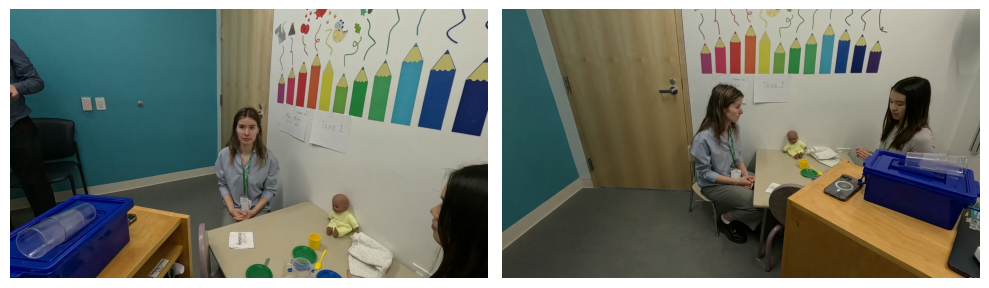

In [3]:
def get_frame(cap, frame_number):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    assert ret # if the frame is not read, we will stop the program
    return frame

def display_frames(frame1, frame2):
    gs = plt.GridSpec(1, 2) # 1 row, 2 columns
    plt.figure(figsize=(10, 6)) # width:10, height:5
    plt.subplot(gs[0, 0]) # select the first cell
    plt.imshow(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(gs[0, 1]) # select the second cell
    plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

fps = 60

# get the frame from each video
video1_frame = get_frame(video1_cap, 0*fps)
video2_frame = get_frame(video2_cap, 0*fps)

display_frames(video1_frame, video2_frame)

### Manually Align the Frames

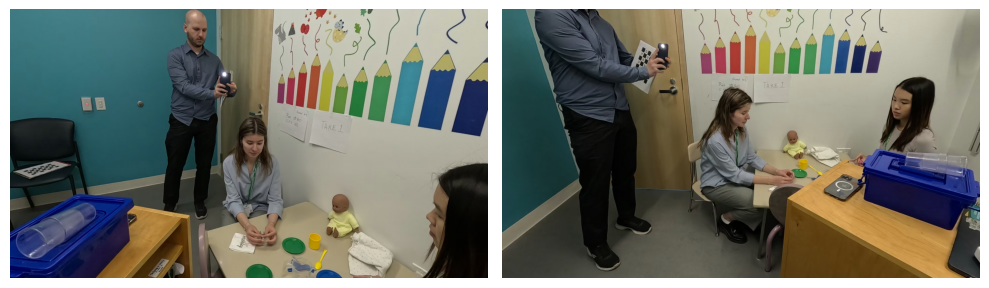

In [4]:
# get the frame from each video
video1_frame = get_frame(video1_cap, 50*fps)
video2_frame = get_frame(video2_cap, 45*fps)

display_frames(video1_frame, video2_frame)

### Refine the search

In [5]:
def frame_reel(video_cap, start_frame, end_frame, step, max_columns=5):
    reel = {}
    for i in range(start_frame, end_frame, step):
        frame = get_frame(video_cap, i)
        reel[i] = frame 

    columns = max_columns if len(reel) > max_columns else len(reel)
    rows = len(reel) // columns 
    rows += 1 if len(reel) % columns else 0
    gs = plt.GridSpec(rows, columns)
    plt.figure(figsize=(columns*4, rows*3))
    for i, (frame_number, frame) in enumerate(reel.items()):
        plt.subplot(gs[i // columns, i % columns])
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.title(f"Frame {frame_number}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#### Find the exact frame where light is turned off for video1

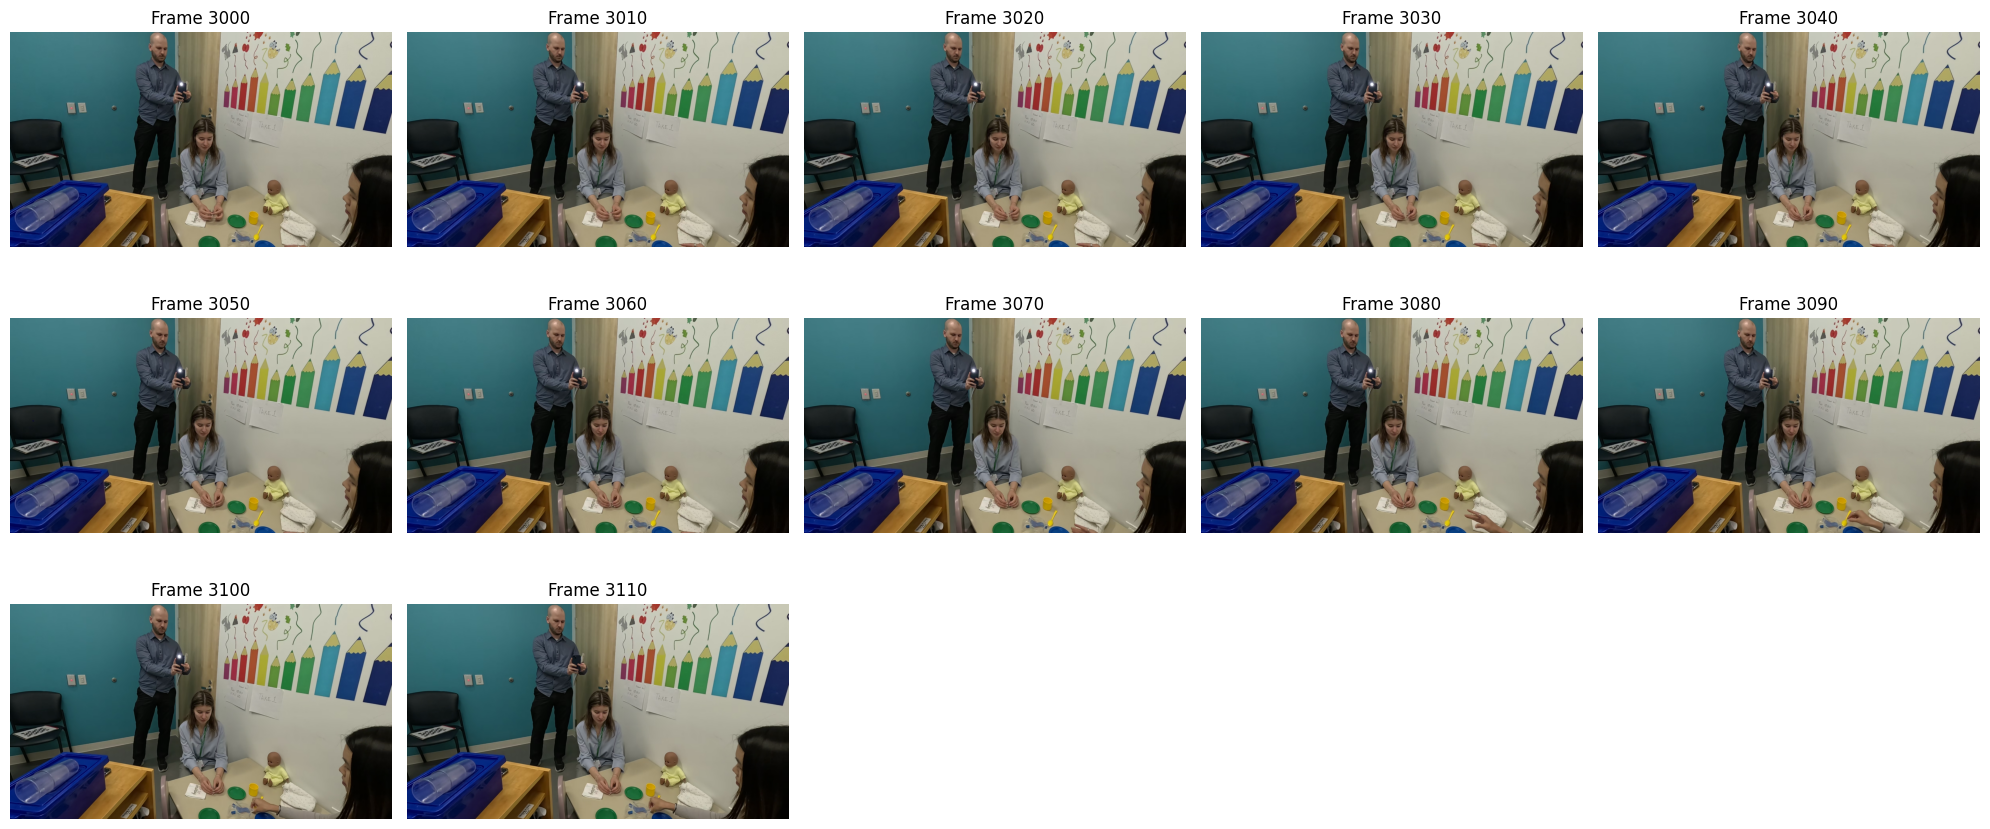

In [6]:
frame_reel(video1_cap, start_frame=50*fps, end_frame=52*fps, step=10)

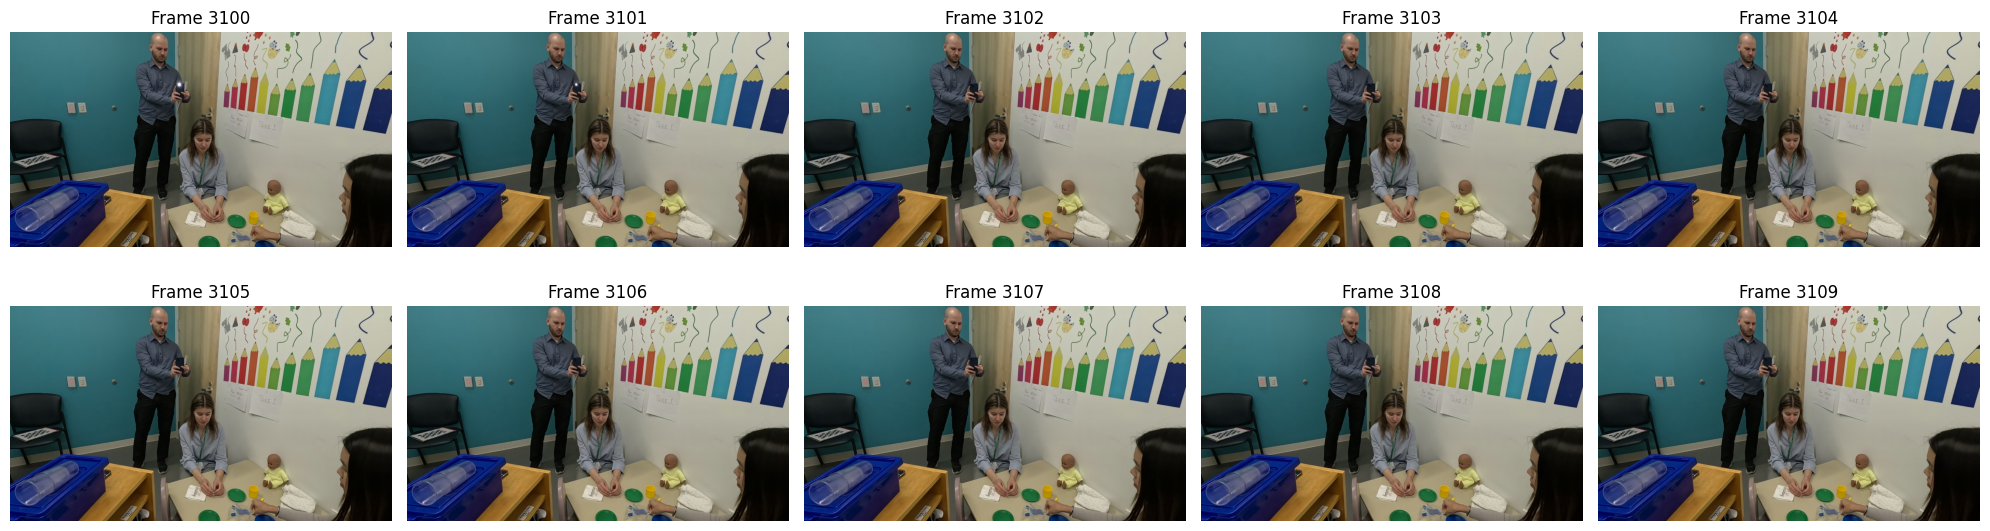

In [7]:
frame_reel(video1_cap, start_frame=3100, end_frame=3110, step=1)

The first frame where there is no light is 3102 in video1

#### Find the first frame where there is no light in video2

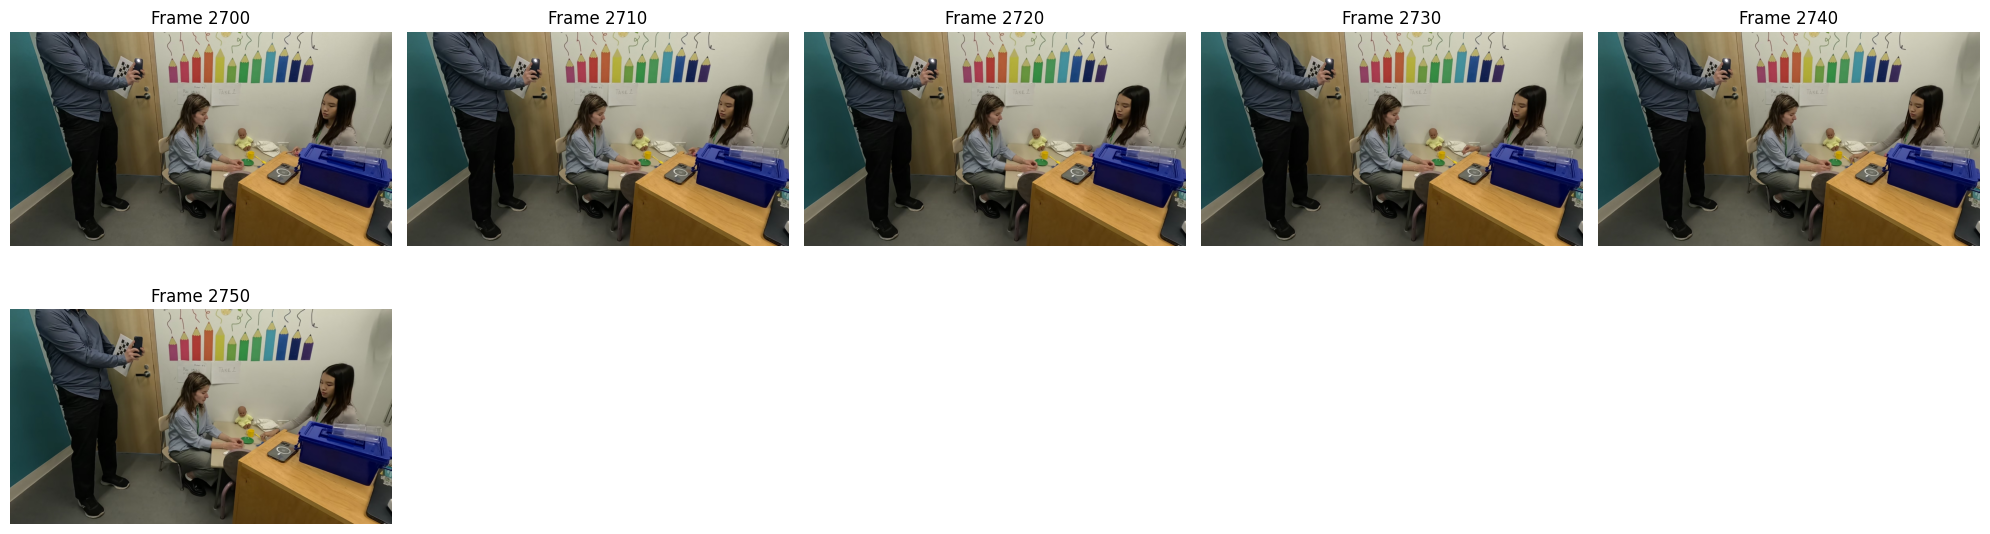

In [8]:
frame_reel(video2_cap, start_frame=45*fps, end_frame=46*fps, step=10)

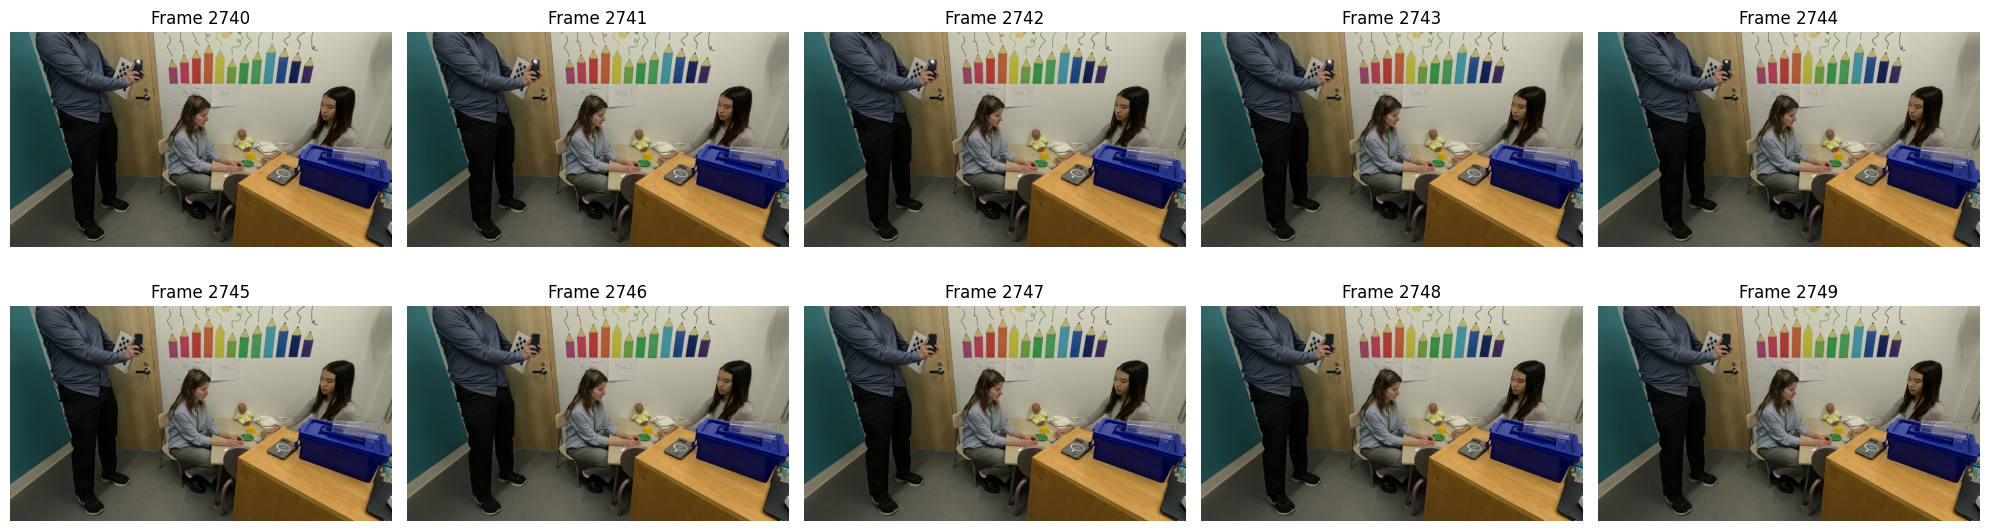

In [9]:
frame_reel(video2_cap, start_frame=2740, end_frame=2750, step=1)

The light is completely off on frame 2745

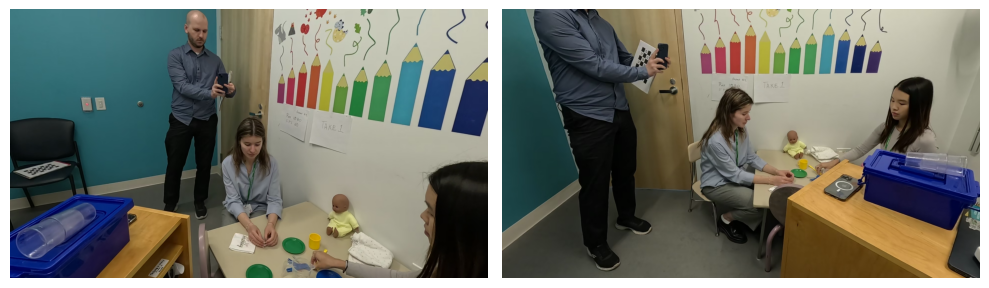

In [10]:
video1_light_off = 3102
video2_light_off = 2745
video1_frame = get_frame(video1_cap, video1_light_off)
video2_frame = get_frame(video2_cap, video2_light_off)
display_frames(video1_frame, video2_frame)

### Align the videos

In [15]:
offset = video1_light_off - video2_light_off
print("Offset", offset) # positive means that video1 is ahead of video2

video1_start = 0
video2_start = 0
if offset > 0:
    video1_start = offset
else:
    video2_start = -offset

adjusted_video1_length = total_frames1
adjusted_video2_length = total_frames2
if offset > 0:
    adjusted_video1_length -= offset
else:
    adjusted_video2_length += offset

print("Video1 Start", video1_start)
print("Video2 Start", video2_start)

print('---')
print("Original Video Lengths", total_frames1, total_frames2)
print("Adjusted Video Lengths", adjusted_video1_length, adjusted_video2_length)
min_length = min(adjusted_video1_length, adjusted_video2_length) 
print("Minimum Length", min_length)

video1_end = min_length
video2_end = min_length
if offset > 0:
    video1_end += offset
else:
    video2_end -= offset

print("Video1 Crop", video1_start, video1_end)
print("Video2 Crop", video2_start, video2_end)

Offset 357
Video1 Start 357
Video2 Start 0
---
Original Video Lengths 13533 13176
Adjusted Video Lengths 13176 13176
Minimum Length 13176
Video1 Crop 357 13533
Video2 Crop 0 13176


In [17]:
video1_fps = float(video1_cap.get(cv2.CAP_PROP_FPS))
video1_start_time = video1_start / video1_fps

video2_fps = float(video2_cap.get(cv2.CAP_PROP_FPS))
video2_start_time = video2_start / video2_fps

duration = min_length / video1_fps


In [32]:
video1_output_path = "data/video1_cropped.mp4"
video2_output_path = "data/video2_cropped.mp4"
!ffmpeg -accurate_seek -i {video1_path} -ss {video1_start_time} -t {duration} -y -c:v copy {video1_output_path}
!ffmpeg -accurate_seek -i {video2_path} -ss {video2_start_time} -t {duration} -y -c:v copy {video2_output_path}

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libso

In [33]:
# Show video lengths of completed videos
video1_output_cap = cv2.VideoCapture(video1_output_path)
video2_output_cap = cv2.VideoCapture(video2_output_path)

total_frames1 = int(video1_output_cap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames2 = int(video2_output_cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total Frames", total_frames1, total_frames2)

Total Frames 13173 13176


In [38]:
! ffmpeg -y -i {video1_output_path} -i {video2_output_path} -filter_complex "vstack=inputs=2" -ss 10 -t 20 data/stacked-test.mp4


ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libso